## Initializing

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [4]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('felipekitamura/spr-x-ray-age-and-gender-dataset', path="/content/", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/felipekitamura/spr-x-ray-age-and-gender-dataset


In [5]:
# Set the base directory (modify this path as needed)
BASE_DIR = '/content/'

In [6]:
# Cell 1: Imports and Setup
import os
import functools
from google.colab import drive
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models

In [7]:
# Enable mixed precision
if tf.config.list_physical_devices('GPU'):
  tf.keras.mixed_precision.set_global_policy('mixed_float16')

## Required functions

In [20]:
# Cell 2: Define helper functions
def validate_path(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        path = args[0] if args else kwargs.get('base_dir')
        if not isinstance(path, str):
            raise TypeError("base_dir must be a string")
        if not os.path.exists(path):
            raise ValueError(f"The path {path} does not exist.")
        return func(*args, **kwargs)
    return wrapper

@validate_path
def load_data(base_dir: str):
    """
    Load age and gender data from CSV files.

    Args:
    base_dir (str): Base directory path containing the CSV files.

    Returns:
    tuple: Pandas DataFrames for age and gender data.
    """
    df_age = pd.read_csv(os.path.join(base_dir, 'train_age.csv'))
    df_gen = pd.read_csv(os.path.join(base_dir, 'train_gender.csv'))
    print(f"Loaded {len(df_age)} samples for age prediction")
    print(f"Loaded {len(df_gen)} samples for gender prediction")
    return df_age, df_gen

def validate_image_path(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        path = args[0] if args else kwargs.get('image_path')
        if not isinstance(path, str):
            raise TypeError("image_path must be a string")
        if not os.path.exists(path):
            raise ValueError(f"The image path {path} does not exist.")
        return func(*args, **kwargs)
    return wrapper

@validate_image_path
def preprocess_image(image_path: str):
    """
    Load and preprocess a single image.

    Args:
    image_path (str): Path to the image file.

    Returns:
    numpy.array: Preprocessed image as a numpy array.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to load image from {image_path}")
    img = 255 - img  # creating the negative of the image
    return cv2.resize(img, (128, 128))

@validate_path
def load_and_preprocess_images(base_dir: str):
    """
    Load and preprocess all images in the specified directory.

    Args:
    base_dir (str): Base directory containing the images.

    Returns:
    numpy.array: Array of preprocessed images.
    """
    image_dir = os.path.join(base_dir, 'kaggle/kaggle/train/')
    images = []
    for i in tqdm(sorted(os.listdir(image_dir)), desc="Processing Images"):
        img = preprocess_image(os.path.join(image_dir, i))
        images.append(img)
    return np.array(images).reshape(-1, 128, 128, 1) / 255.0

def validate_model_params(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        output_units = kwargs.get('output_units')
        activation = kwargs.get('activation')
        dense_units = kwargs.get('dense_units')
        if not isinstance(output_units, int) or output_units <= 0:
            raise ValueError("output_units must be a positive integer")
        if not isinstance(activation, str):
            raise TypeError("activation must be a string")
        if not isinstance(dense_units, list) or not all(isinstance(x, int) and x > 0 for x in dense_units):
            raise ValueError("dense_units must be a list of positive integers")
        return func(*args, **kwargs)
    return wrapper

@validate_model_params
def create_flexible_model(output_units: int, activation: str, dense_units: list, dropout_rate: float = 0.3):
    """
    Create a flexible model with customizable dense layers.

    Args:
    output_units (int): Number of units in the output layer.
    activation (str): Activation function for the output layer.
    dense_units (list): List of integers representing the number of units in each dense layer.
    dropout_rate (float): Dropout rate for regularization.

    Returns:
    tensorflow.keras.Model: Compiled Keras model.
    """
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(4, 3, padding='same', input_shape=(128, 128, 1)),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        layers.Conv2D(16, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2 , strides = 2, padding = 'same'),

        layers.Conv2D(32, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2 , strides = 2, padding = 'same'),

        layers.Conv2D(64, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2 , strides = 2, padding = 'same'),

        layers.Conv2D(128, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2 , strides = 2, padding = 'same'),

        layers.Conv2D(128, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2 , strides = 2, padding = 'same'),

        layers.Conv2D(64, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),
        layers.Flatten()
    ])

    # Add flexible dense layers
    for units in dense_units:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(output_units, activation=activation))

    return model

def plot_training_history(history_gender, history_age):
    """
    Plot the training history for both gender and age models.

    Args:
    history_gender: Training history of the gender model.
    history_age: Training history of the age model.
    """
    plt.figure(figsize=(20, 6))

    plt.subplot(121)
    plt.plot(history_gender.history['accuracy'], label='Train Accuracy')
    plt.plot(history_gender.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Gender Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(122)
    plt.plot(history_age.history['mse'], label='Train MSE')
    plt.plot(history_age.history['val_mse'], label='Validation MSE')
    plt.title('Age Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_learning_rates(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.show()

def evaluate_gender_model(model, X_test, y_test):
    """
    Evaluate the gender prediction model and print metrics.

    Args:
    model: Trained gender prediction model.
    X_test: Test features.
    y_test: True labels for the test set.
    """
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("Gender Model Metrics:")
    print("Accuracy   :", accuracy_score(y_test, y_pred))
    print("Precision  :", precision_score(y_test, y_pred))
    print("Recall     :", recall_score(y_test, y_pred))
    print("F1-score   :", f1_score(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.ylabel('Prediction', fontsize=13)
    plt.xlabel('Actual', fontsize=13)
    plt.title('Confusion Matrix (Gender)', fontsize=17)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_age_model(model, X_test, y_test):
    """
    Evaluate the age prediction model and print metrics.

    Args:
    model: Trained age prediction model.
    X_test: Test features.
    y_test: True labels for the test set.
    """
    y_pred = model.predict(X_test).flatten()
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    mse = np.mean((y_test - y_pred)**2)

    print("\nAge Model Metrics:")
    print(f"R2 Score   : {r2:.4f}")
    print(f"MAE        : {mae:.4f}")
    print(f"MSE        : {mse:.4f}")
    print(f"RMSE       : {np.sqrt(mse):.4f}")

    plt.figure(figsize=(12, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('Age Prediction: Actual vs Predicted')

    # Add text box with metrics
    textstr = f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {np.sqrt(mse):.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
             verticalalignment='top', bbox=props)

    plt.show()

    # Residual Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(12, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.xlabel('Predicted Age')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

## Load and preprocess data

In [9]:
df_age, df_gen = load_data(BASE_DIR)
X = load_and_preprocess_images(BASE_DIR)
y_age = np.array(df_age['age'])
y_gender = np.array(df_gen['gender'])

Loaded 10702 samples for age prediction
Loaded 10702 samples for gender prediction


Processing Images:   0%|          | 0/10702 [00:00<?, ?it/s]

## Creating datasets

In [10]:
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    X, y_age, y_gender, test_size=0.2, random_state=42
)

In [11]:
# Define augmentation function
def augment(image, label,
            do_rotate=True,
            do_shift=True,
            do_flip=True,
            do_color_jitter=False,  # New method, off by default
            do_cutout=False):  # New method, off by default
    """
    Apply configurable data augmentation to the input image.

    Args:
    image: Input image tensor
    label: Corresponding label
    do_rotate: Whether to apply random rotation
    do_shift: Whether to apply random shift
    do_flip: Whether to apply random horizontal flip
    do_color_jitter: Whether to apply color jittering
    do_cutout: Whether to apply cutout

    Returns:
    Tuple of (augmented image, label)
    """
    # Convert to float32 if not already
    image = tf.cast(image, tf.float32)

    if do_rotate:
        # Random rotation
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    if do_shift:
        # Random width and height shift
        image = tf.image.random_crop(tf.image.pad_to_bounding_box(image, 4, 4, 136, 136), (128, 128, 1))

    if do_flip:
        # Random horizontal flip
        image = tf.image.random_flip_left_right(image)

    if do_color_jitter:
        # Color jittering
        image = color_jitter(image)

    if do_cutout:
        # Cutout
        image = cutout(image)

    # Ensure pixel values are in [0, 1] range
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

# Set up dataset for gender prediction
def create_dataset(X, y, is_training=True, cache=True, batch_size=32, **augment_args):
    """
    Create a tf.data.Dataset with augmentation and prefetching.

    Args:
    X: Input features
    y: Labels
    is_training: Boolean to indicate if this is for training (to apply augmentation)

    Returns:
    tf.data.Dataset object
    """
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.map(lambda x, y: augment(x, y, **augment_args), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size)
    else:
        dataset = dataset.batch(batch_size)

    if cache:
        dataset = dataset.cache()

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

augmentation_config = {
    'do_rotate': True,
    'do_shift': True,
    'do_flip': True,
    'do_color_jitter': False,  # New method, off by default
    'do_cutout': False  # New method, off by default
}

# Create datasets
train_dataset_gender = create_dataset(X_train, y_gender_train, is_training=True, **augmentation_config)
test_dataset_gender = create_dataset(X_test, y_gender_test, is_training=False)

train_dataset_age = create_dataset(X_train, y_age_train, is_training=True, **augmentation_config)
test_dataset_age = create_dataset(X_test, y_age_test, is_training=False)

# Learning rate schedule
def lr_schedule(epoch):
    lr = 1e-2
    if epoch < 10:
        lr *= 0.1
    elif epoch >= 10:
        lr *= 0.01
    return lr


## Compiling models

In [12]:
model_gender = create_flexible_model(output_units=1, activation='sigmoid', dense_units=[10])
model_gender.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule(0)),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

model_age = create_flexible_model(output_units=1, activation='linear', dense_units=[100, 50])
model_age.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
                  loss='mse',
                  metrics=['mse'])

# Print model summaries
print("Gender Model Summary:")
model_gender.summary()
print("\nAge Model Summary:")
model_age.summary()

# Callbacks
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_schedule)
]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Gender Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 4)         │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 4)         │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 16)        │             592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 128)           │              

 Total params: 321,405 (1.23 MB)

 Trainable params: 320,533 (1.22 MB)

 Non-trainable params: 872 (3.41 KB)


Age Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 4)         │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128, 128, 4)         │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 128, 128, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 16)        │             592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │              

 Total params: 332,345 (1.27 MB)

 Trainable params: 331,473 (1.26 MB)

 Non-trainable params: 872 (3.41 KB)

## Training models

In [13]:
epochs = 30

history_gender = model_gender.fit(
    train_dataset_gender,
    epochs=epochs,
    validation_data=test_dataset_gender,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.6846 - loss: 0.5917 - val_accuracy: 0.5325 - val_loss: 0.9499 - learning_rate: 0.0010
Epoch 2/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8045 - loss: 0.4466 - val_accuracy: 0.8132 - val_loss: 0.4540 - learning_rate: 0.0010
Epoch 3/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8515 - loss: 0.3761 - val_accuracy: 0.7356 - val_loss: 0.5896 - learning_rate: 0.0010
Epoch 4/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8760 - loss: 0.3143 - val_accuracy: 0.6376 - val_loss: 0.9501 - learning_rate: 0.0010
Epoch 5/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9046 - loss: 0.2713 - val_accuracy: 0.8674 - val_loss: 0.3045 - learning_rate: 0.0010
Epoch 6/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9242 - loss: 0.2206 - val_accuracy: 0.8066 - val_loss: 0.4472 - learning_rate: 0.0010
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9363 - loss: 0.2015 

In [14]:
epochs = 30
history_age = model_age.fit(
    train_dataset_age,
    epochs=epochs,
    validation_data=test_dataset_age,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - loss: 1505.4208 - mse: 1505.4333 - val_loss: 493.9472 - val_mse: 493.9505 - learning_rate: 0.0010
Epoch 2/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 314.5573 - mse: 314.5546 - val_loss: 789.8879 - val_mse: 789.8837 - learning_rate: 0.0010
Epoch 3/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 246.5927 - mse: 246.5927 - val_loss: 576.5982 - val_mse: 576.5986 - learning_rate: 0.0010
Epoch 4/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 222.7488 - mse: 222.7490 - val_loss: 611.2054 - val_mse: 611.2189 - learning_rate: 0.0010
Epoch 5/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 206.4946 - mse: 206.4946 - val_loss: 827.1120 - val_mse: 827.1134 - learning_rate: 0.0010
Epoch 6/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 195.8786 - mse: 195.8789 - val_loss: 260.1908 - val_mse: 260.1909 - learning_rate: 0.0010
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 189.9619 - mse: 189.9609 - val_loss:

## Training history

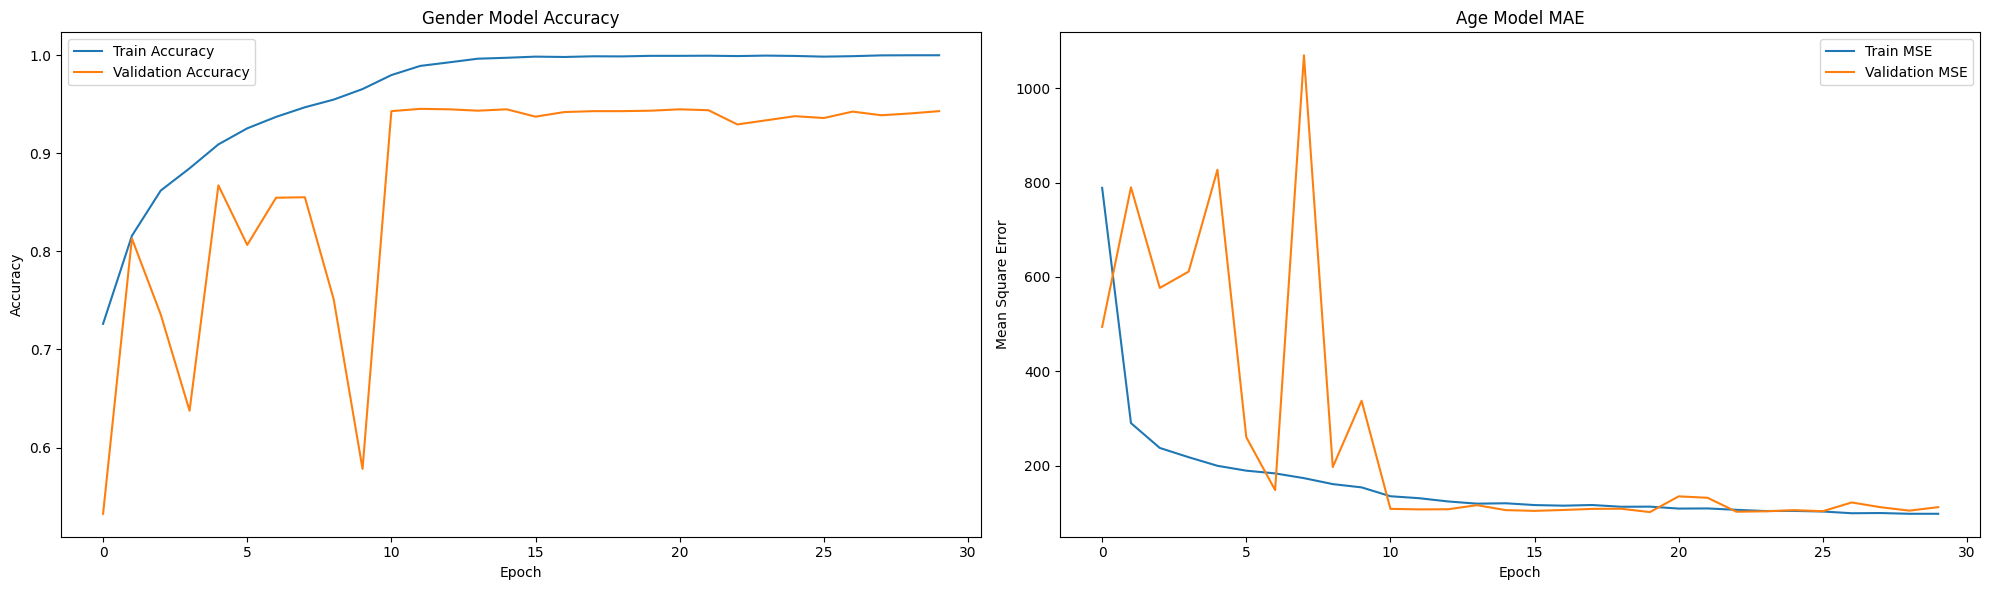

In [15]:
plot_training_history(history_gender, history_age)

In [18]:
model_gender.save('/content/drive/MyDrive/ML/AgeGender/model_gender.keras')
model_age.save('/content/drive/MyDrive/ML/AgeGender/model_age.keras')
print("Models saved to Google Drive")

Models saved to Google Drive


## Evaluating

Evaluating Gender Model:
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Gender Model Metrics:
Accuracy   : 0.9430172816440916
Precision  : 0.9462616822429907
Recall     : 0.9142212189616253
F1-score   : 0.9299655568312285


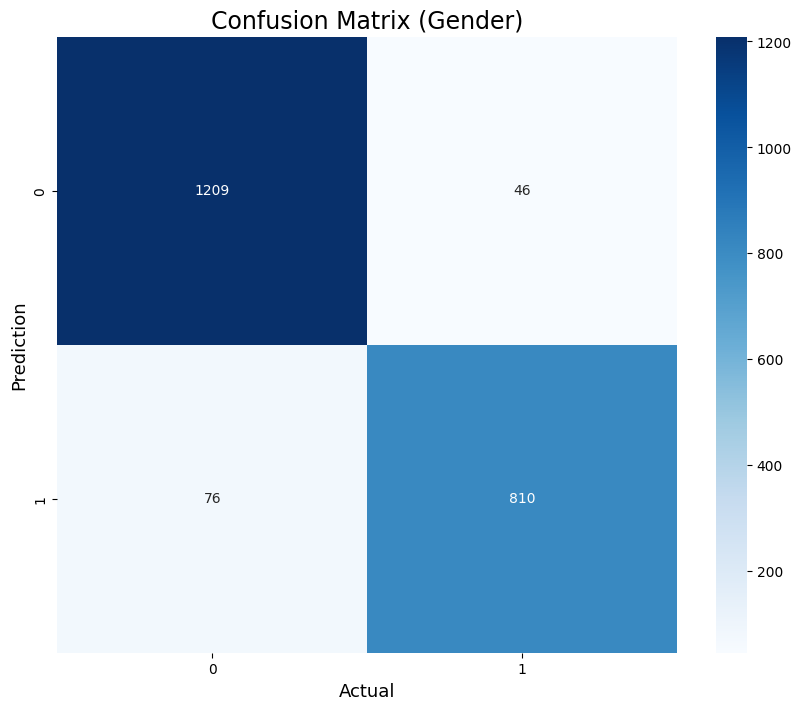

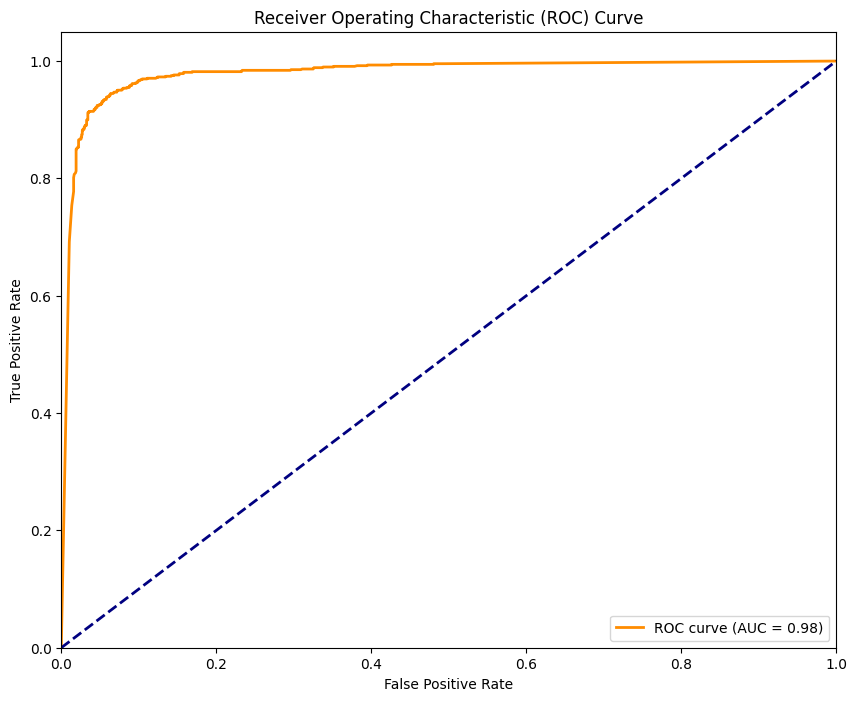

In [21]:
print("Evaluating Gender Model:")
evaluate_gender_model(model_gender, X_test, y_gender_test)


Evaluating Age Model:
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

Age Model Metrics:
R2 Score   : 0.6814
MAE        : 8.3125
MSE        : 111.9287
RMSE       : 10.5796


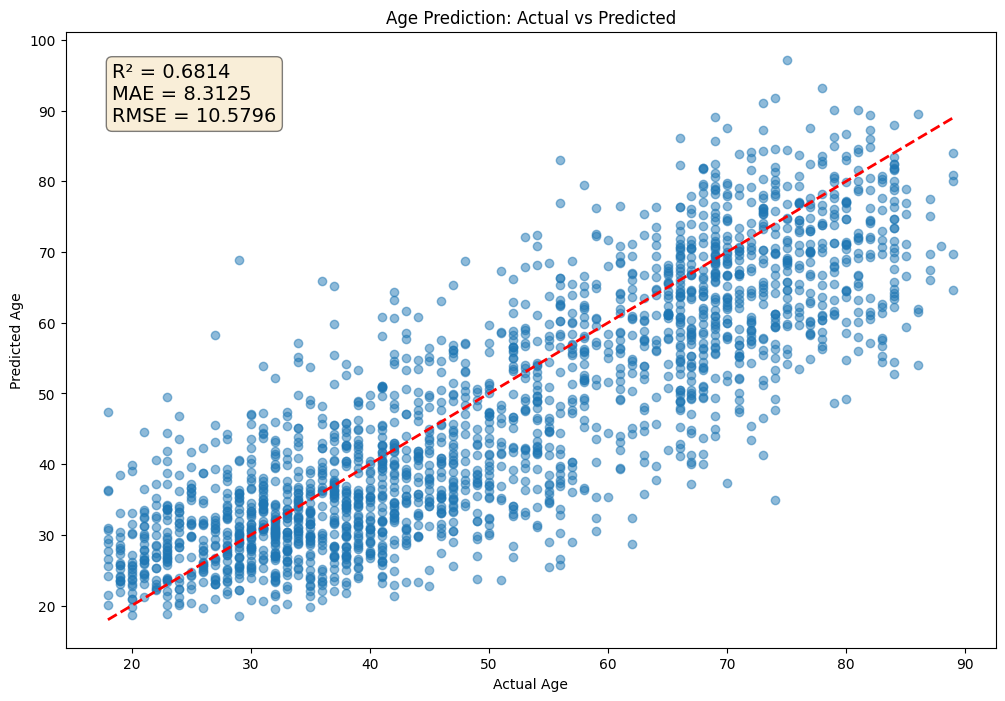

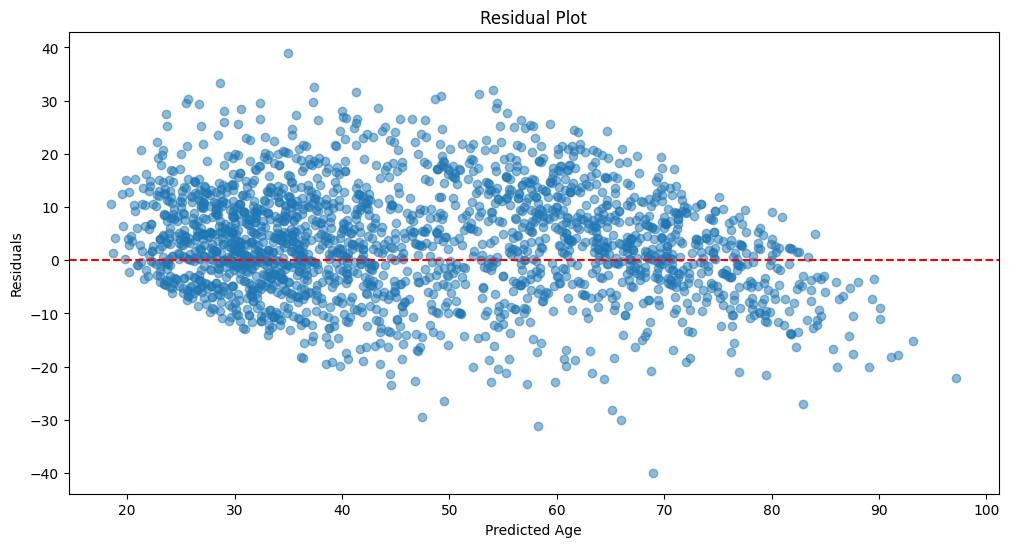

In [22]:
print("\nEvaluating Age Model:")
evaluate_age_model(model_age, X_test, y_age_test)